# Прогнозирование оттока клиентов

**Описание бизнес-задачи:**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

**Цель проекта:** провести анализ и подготовить план действий по удержанию клиентов.  

**Задачи проекта:**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

## Оглавление:

[Загрузка данных](#load)

[Исследовательский анализ данных (EDA)](#eda)

[Прогнозирование оттока клиентов](#models)

[Кластеризация клиентов](#clasters)

[Выводы и базовые рекомендации](#conclusion_part)

## Загрузка данных
<a id="load"></a> 

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
try:
    df = pd.read_csv('gym_churn.csv') #локальный запуск
except:
    df = pd.read_csv('/datasets/gym_churn.csv') #запуск в среде Практикума

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Всего в наборе данных 14 колонок и 4000 строк. Присутствуют типы данных int64 и float64. Категориальных данных, подлежащих преобразованию, нет.

## Исследовательский анализ данных (EDA)
<a id="eda"></a> 

Проверим, есть ли пропущенные значения в датасете:

In [5]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
gender,0.000000
Near_Location,0.000000
Partner,0.000000
Promo_friends,0.000000
Phone,0.000000
Contract_period,0.000000
Group_visits,0.000000
Age,0.000000
Avg_additional_charges_total,0.000000
Month_to_end_contract,0.000000


Пропущенных значений нет.

In [6]:
df.duplicated().sum()

0

Дубликатов не обнаружено.

Посмотрим на средние значения и стандартные отклонения числовых столбцов:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Некоторые показатели уже переведены в бинарный формат и состоят из 2х значений: 0 - нет, 1 - да. В таких столбцах стандартное отклонение не превышает 0,5. 

В некоторых же столбцах присутствуют данные с разной шкалой измерений, например: возраст (от 18 до 41), сумма трат (от 0,14 до 552,6) и другие. В таких столбцах стандартное отклонение уже зависит от диапазона измерений.

В качестве **целевой переменной** в данном проекте выступает показатель факта оттока клиентов: 0 - нет, 1 - да.

Изучим распределение целевой переменной.

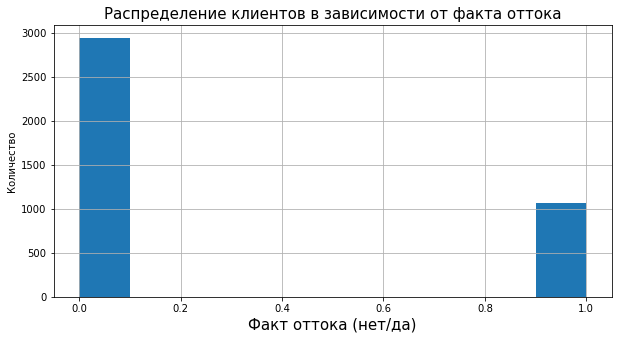

In [8]:
plt.figure(figsize=(10,5))
df['Churn'].hist()

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Факт оттока (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от факта оттока', fontsize=15)
plt.show()

In [9]:
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Доля ушедших клиентов составляет около 1/4 от всех клиентов за предшествующий месяц.

Посмотрим на среднее значение признаков в зависимости от группы: 0 - не попали в отток, 1 - попали в отток.

In [10]:
mean_group_by_churn = df.groupby('Churn').mean()
mean_group_by_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В некоторых признаках средние значения практически не отличаются, например: пол, возраст, указание номера телефона. В некоторых признаках средние значения сильно разнятся в зависимости от группы. Изучим каждый признак подробнее:

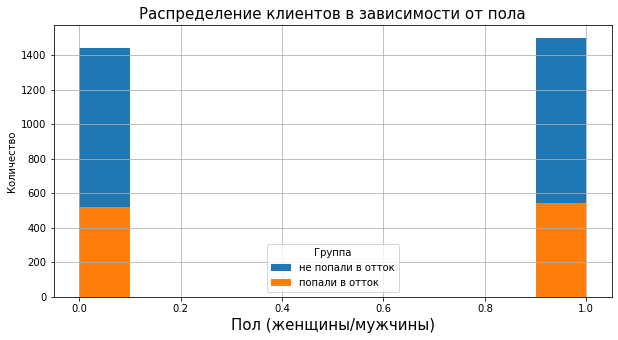

In [11]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['gender'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['gender'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Пол (женщины/мужчины)', fontsize=15)
plt.title('Распределение клиентов в зависимости от пола', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Как было видно по средним значениям, количество клиентов разного пола приблизительно одинаково в группе ушедших и сохранившихся клиентов. Вряд ли по данному признаку можно оценивать факт оттока.

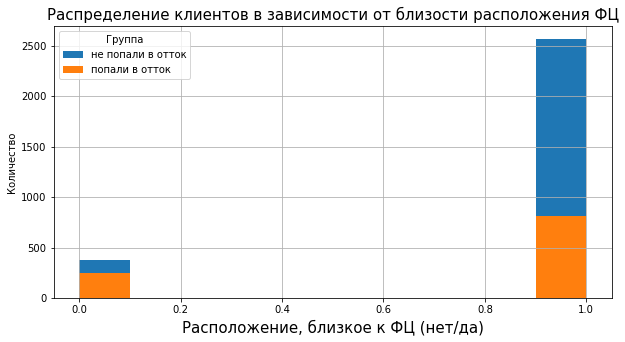

In [12]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Near_Location'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Near_Location'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Расположение, близкое к ФЦ (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от близости расположения ФЦ', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Среди клиентов, которые проживают/работают близко к ФЦ гораздо больше тех, кто остался в качестве клиента. По предварительной оценке этот фактор может оказывать влияние на отток.

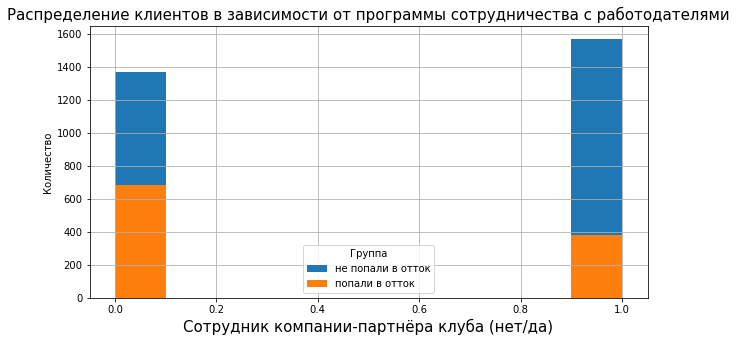

In [13]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Partner'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Partner'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Сотрудник компании-партнёра клуба (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от программы сотрудничества с работодателями', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Программа сотрудничества ФЦ (здесь и далее в значении "фитнес-центр") с работодателями оказывает положительное влиение на удержание клиентов. Среди группы оставшихся в 4 раза больше клиентов, участвующих в данной программе.

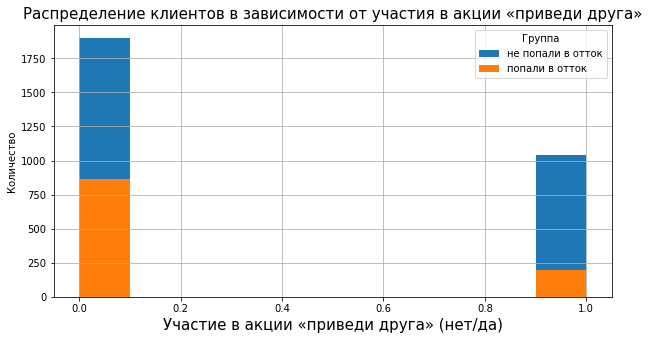

In [14]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Promo_friends'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Promo_friends'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Участие в акции «приведи друга» (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от участия в акции «приведи друга»', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Только около 1/4 клиентов использовали промокод при оплате первого абонемента. Среди тех, кто участвовал в акции, доля оставшихся значительно больше. Среди тех, кто не участвовал, доли оставшихся/ушедших клиентов распределились в соотношении 2 к 1.

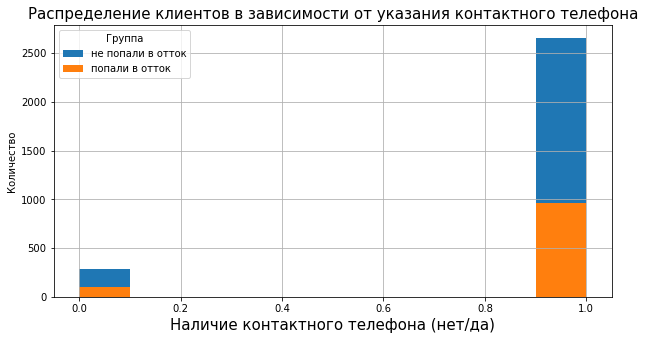

In [15]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Phone'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Phone'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Наличие контактного телефона (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от указания контактного телефона', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Большинство клиентов ФЦ оставляют контактный номер телефона. Среди тех, кто оставил номер телефона, в 2,5 раза больше тех, кто продолжил посещение ФЦ.

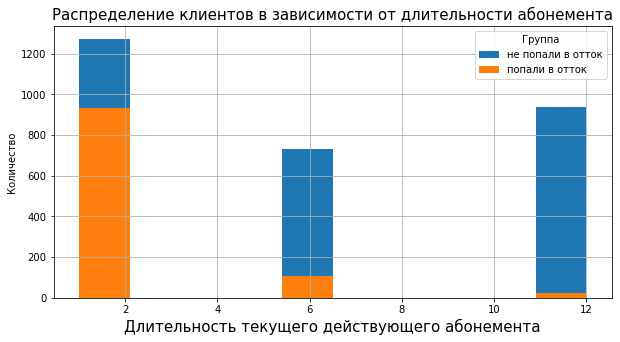

In [16]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Contract_period'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Contract_period'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Длительность текущего действующего абонемента', fontsize=15)
plt.title('Распределение клиентов в зависимости от длительности абонемента', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Доля ушедших клиентов резко уменьшается с возрастанием длительности действующего абонемента (1 - 6 - 12 мес.). Среди клиентов, которые берут годовые абонементы, практически нет оттока. Этот фактор, предположительно, может оказывать сильное влияние на факт оттока.

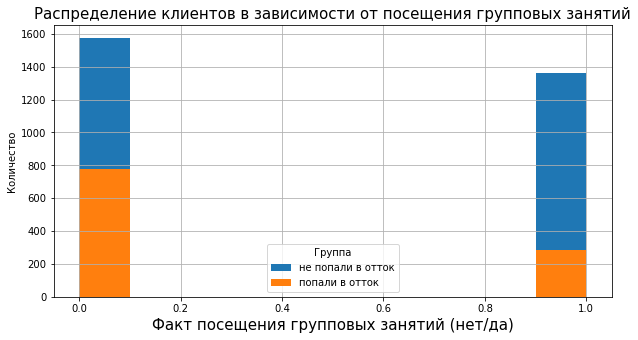

In [17]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Group_visits'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Group_visits'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Факт посещения групповых занятий (нет/да)', fontsize=15)
plt.title('Распределение клиентов в зависимости от посещения групповых занятий', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Среди попавших в отток клиентов в 2,6 раза больше тех, кто не посещал групповые занятия.

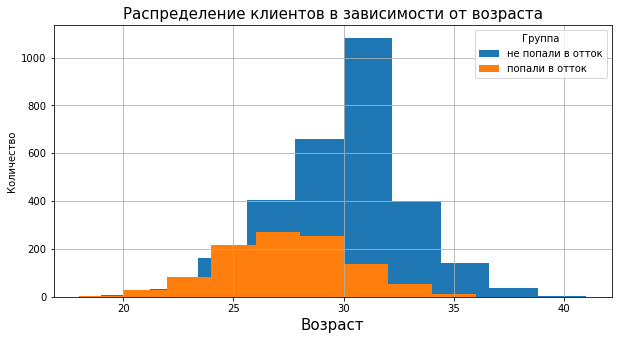

In [18]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Age'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Age'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Возраст', fontsize=15)
plt.title('Распределение клиентов в зависимости от возраста', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Группа ушедших клиентов выглядит немного моложе, чем оставшихся. Распределения похожи на нормальные.

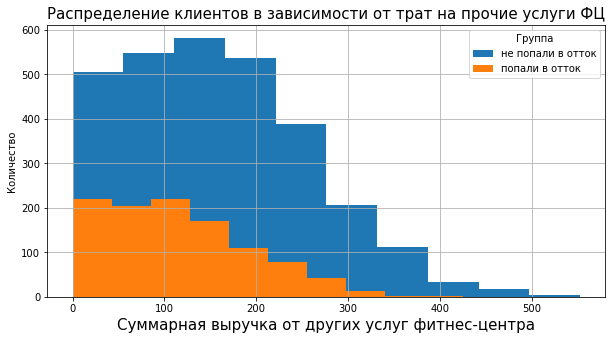

In [19]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Avg_additional_charges_total'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Avg_additional_charges_total'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Суммарная выручка от других услуг фитнес-центра', fontsize=15)
plt.title('Распределение клиентов в зависимости от трат на прочие услуги ФЦ', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Распределения попаших/не попавших в отток клиентов похожи, имеют скос вправо. Среди оставшихся клиентов средний чек все же немного выше.

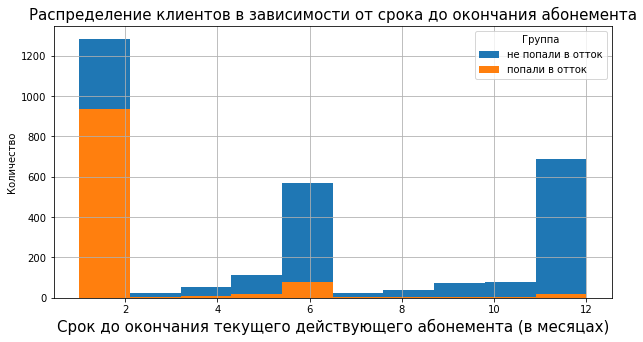

In [20]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Month_to_end_contract'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Month_to_end_contract'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Срок до окончания текущего действующего абонемента (в месяцах)', fontsize=15)
plt.title('Распределение клиентов в зависимости от срока до окончания абонемента', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Больше всего ушедших клиентов с малым сроком до окончания абонемента (1 мес.). Менее 100 чел. ушли, когда до окончания действия абонемента оставалось еще полгода. Есть и те, кто купили годовой абонемент и прекратили занятия, но таких уже единицы. Распределения имеют явно выраженные пики в 1, 6 и 12 мес., так как это как раз временные отсечки длительности имеющихся в продаже абонементов. Получается, большинство ушедших прекращают занятия после покупки месячного абонемента, т.е. в самом начале.

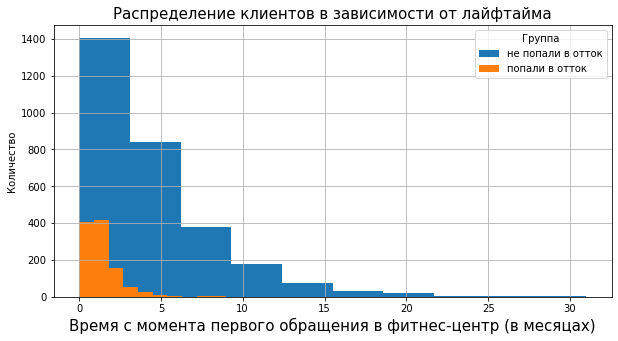

In [21]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Lifetime'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Lifetime'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Время с момента первого обращения в фитнес-центр (в месяцах)', fontsize=15)
plt.title('Распределение клиентов в зависимости от лайфтайма', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Среди попавших в отток клиенты, которые только недавно обратились в ФЦ (в основном, менее 3 мес. назад), что вполне соответствует графику оттока в зависимости от длительности абонемента. Видимо, ФЦ существует/ведет статистику не более 3 лет, так как самому "старому" клиенту не более 31 мес. Распределения явно скошены вправо.

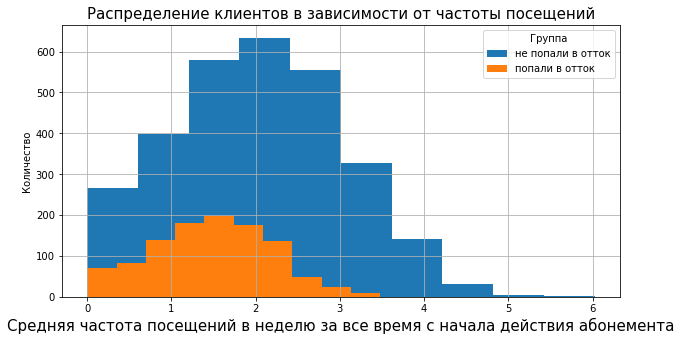

In [22]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Avg_class_frequency_total'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Avg_class_frequency_total'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Средняя частота посещений в неделю за все время с начала действия абонемента', fontsize=15)
plt.title('Распределение клиентов в зависимости от частоты посещений', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Среди продолжающихся заниматься клиентов средняя частота посещений занятий немного выше, чем среди ушедших (2 против 1,5 раз). Распределения похожи на нормальные с небольшим скосом вправо.

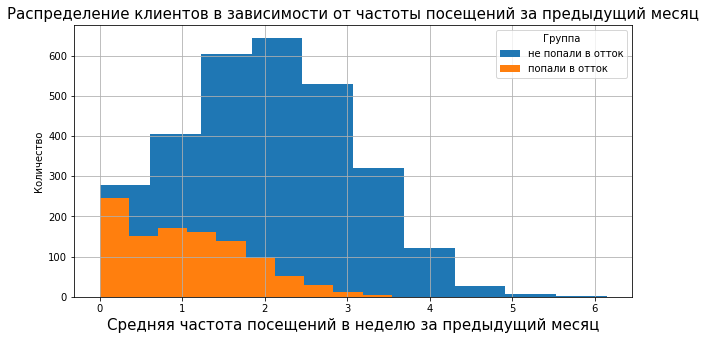

In [23]:
plt.figure(figsize=(10,5))
df[df['Churn'] == 0]['Avg_class_frequency_current_month'].hist(label = 'не попали в отток')
df[df['Churn'] == 1]['Avg_class_frequency_current_month'].hist(label = 'попали в отток')

plt.ylabel('Количество', fontsize=10)
plt.xlabel('Средняя частота посещений в неделю за предыдущий месяц', fontsize=15)
plt.title('Распределение клиентов в зависимости от частоты посещений за предыдущий месяц', fontsize=15)
plt.legend(title= 'Группа', title_fontsize = 10,  prop = {'size' : 10})
plt.show()

Ушедшие клиенты, в среднем, занимались гораздо реже в предшествующем оттоку месяце, нежели оставшиеся клиенты (1 раз против 2 раз). Распределение оставшихся клиентов скошено вправо, кто-то ходит в ФЦ чуть ли не каждый день! Распределение ушедших клиентов так же скошено вправо, но с гораздо более скромными максимальными значениями (до 3,5 раз в неделю). Этот фактор тоже может быть в списке оказывающих влияние на отток клиентов.

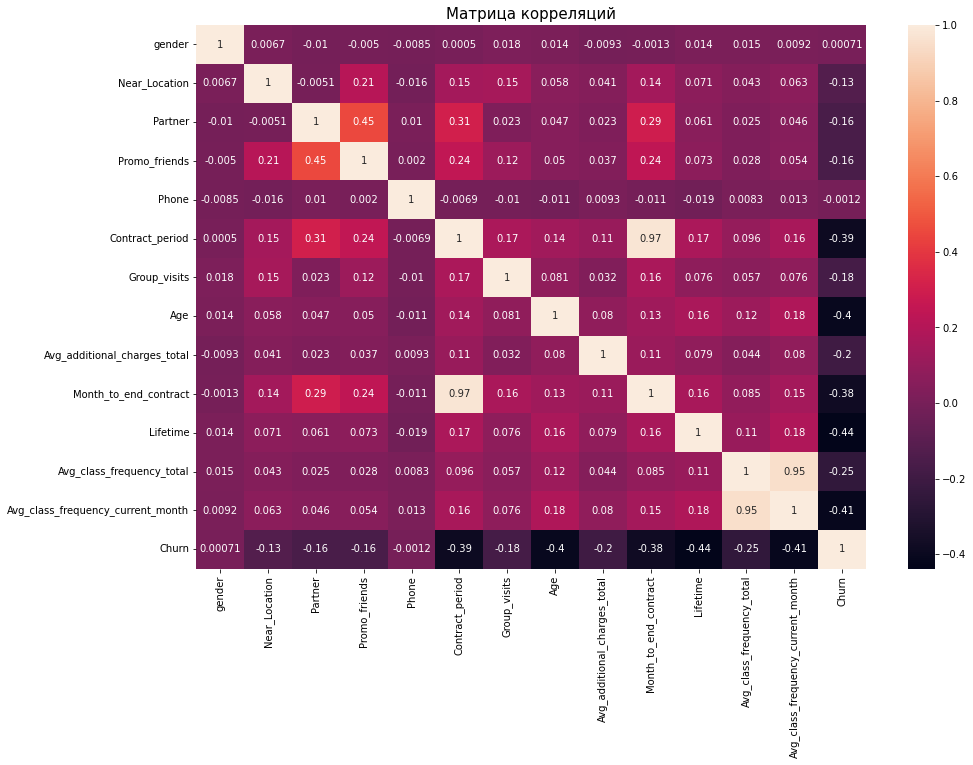

In [24]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.title('Матрица корреляций', fontsize=15)
plt.show()

С целевой переменной, судя по матрице, больше всего коррелируют "срок жизни" клиента, средняя посещаемость за предыдущий месяц, возраст, длительность абонемента и срок до его окончания.

По графику можно отследить эффект мультиколлинеарности между проверяемыми факторами: длительность абонемента и срок до его окончания, средняя частота посещений в неделю и средняя частота посещений за предыдущий месяц. В дальнейшем будем принимать этот факт во внимание при построении модели.

## Выводы по разделу:


- пропущенных значений не обнаружено;
- дубликатов не обнаружено;
- выбросов, способных повлиять на качество будущей модели, не обнаружено;
- исследование отдельных признаков в разрезе факта оттока показало, что некоторые из них могут оказывать влияние на целевую переменную (факт оттока) с большей вероятностью, некоторые с меньшей, что будет выявлено в дальнейшем на этапе построения модели;
- матрица корреляций позволила выявить эффект мультиколлинеарности признаков: длительность абонемента и срок до его окончания, средняя частота посещений в неделю и средняя частота посещений за предыдущий месяц сильно коррелируют между собой. С целевой переменной на данном этапе больше всего коррелируют следующие признаки: лайфтайм клиента, частота посещений за предыдущий месяц, возраст, длительность абонемента и срок до его окончания;
- качество исходных данных принято соответствующим для перехода к этапу моделирования.

##  Прогнозирование оттока клиентов
<a id="models"></a> 

In [25]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns='Churn') #ваш код здесь
y = df['Churn'] #ваш код здесь

In [26]:
# разделяем модель на обучающую и валидационную выборки в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Поскольку числовые данные представлены в различных шкалах, стандартизируем их:

In [27]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

In [28]:
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

Выбирать по метрикам лучшую модель будем из следующих алгоритмов: логистическая регрессия, случайный лес.

In [29]:
# список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0)
]

In [30]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    print(
        'accuracy:{:.2f} precision:{:.2f} recall:{:.2f} F1:{:.2f} ROC_AUC: {:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, probabilities)
        )
    )
    print()

In [31]:
# выведем результаты работы моделей на стандартизированных данных
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0)
accuracy:0.94 precision:0.90 recall:0.85 F1:0.87 ROC_AUC: 0.98

RandomForestClassifier(random_state=0)
accuracy:0.92 precision:0.88 recall:0.83 F1:0.85 ROC_AUC: 0.97



Метрика доли правильных ответов хорошо показала себя в обоих алгоритмах: логистической регрессии и случайном лесу (94% и 92%). Метрики точности (precision) и полноты (recall) тоже достаточно высокие (более 83%), однако немного лучше результаты у логистической регрессии. То есть обученная модель логистической регресии дает 90% правильных ответов среди целевого класса, т.е. тех, кто попадет в отток, и долю правильно обнаруженных реально ушедших клиентов в 85%. Метрики F1 и ROC_AUC так же оказались чуть лучше у логистической регрессии.

In [32]:
# обучим финальную модель
final_model = LogisticRegression(random_state=0)
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

Изучим важность признаков, повлиявших на принятие обученной моделью решения:

In [33]:
# важность признаков - список коэффициентов 
importance = final_model.coef_[0]

importances = pd.DataFrame({'feature': X.columns, 'coeff': pd.Series(importance)})
importances['abs_coeff'] = importances['coeff'].abs()
importances.sort_values('abs_coeff', ascending = False)

,feature,coeff,abs_coeff
12,Avg_class_frequency_current_month,-4.213410,4.213410
10,Lifetime,-3.581257,3.581257
11,Avg_class_frequency_total,3.111962,3.111962
7,Age,-1.167067,1.167067
5,Contract_period,-0.703639,0.703639
9,Month_to_end_contract,-0.631972,0.631972
8,Avg_additional_charges_total,-0.571299,0.571299
6,Group_visits,-0.401414,0.401414
3,Promo_friends,-0.143413,0.143413
2,Partner,-0.066479,0.066479


Судя по модулю коэффициентов наиболее важными признаками стали: Avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), Lifetime (время с момента первого обращения в фитнес-центр (в месяцах)), Avg_class_frequency_total (средняя частота посещений в неделю за все время с начала действия абонемента). И далее, уже в меньшей степени, возраст и длительность абонемента. 

Исходя их проведенного ранее анализа отдельных признаков, эти факторы так же показались наиболее весомыми для факта оттока клиентов, поэтому можно утверждать, что выбранная нами модель адекватна.

## Выводы по разделу:

- данные были разделены на обучающую и валидационную выборки в соотношении 80/20;
- применена стандартизация для обучающей матрицы признаков;
- применена стандартизация к матрице признаков для тестовой выборки;
- были обучены 2 модели по алгоритмам логистической регресии и случайного леса;
- обе модели показали высокие результаты по выбранным метрикам:  accuracy, precision и recall;
- на основании метрик precision и recall лучше себя показала модель логистической регрессии;
- среди наиболее влиятельных факторов были выделены: **средняя частота посещений в неделю за предыдущий месяц, время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за все время с начала действия абонемента.**

## Кластеризация клиентов
<a id="clasters"></a> 

In [34]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(df.drop(columns = ['Churn'])) # обучаем нормализатор и преобразуем набор данных 

In [35]:
linked = linkage(X_sc, method = 'ward') 

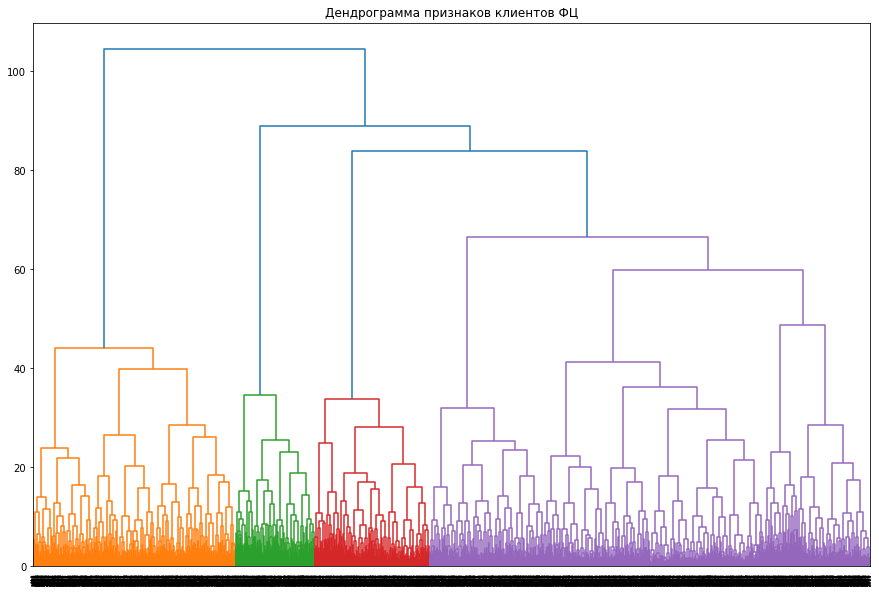

In [36]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков клиентов ФЦ')
plt.show() 

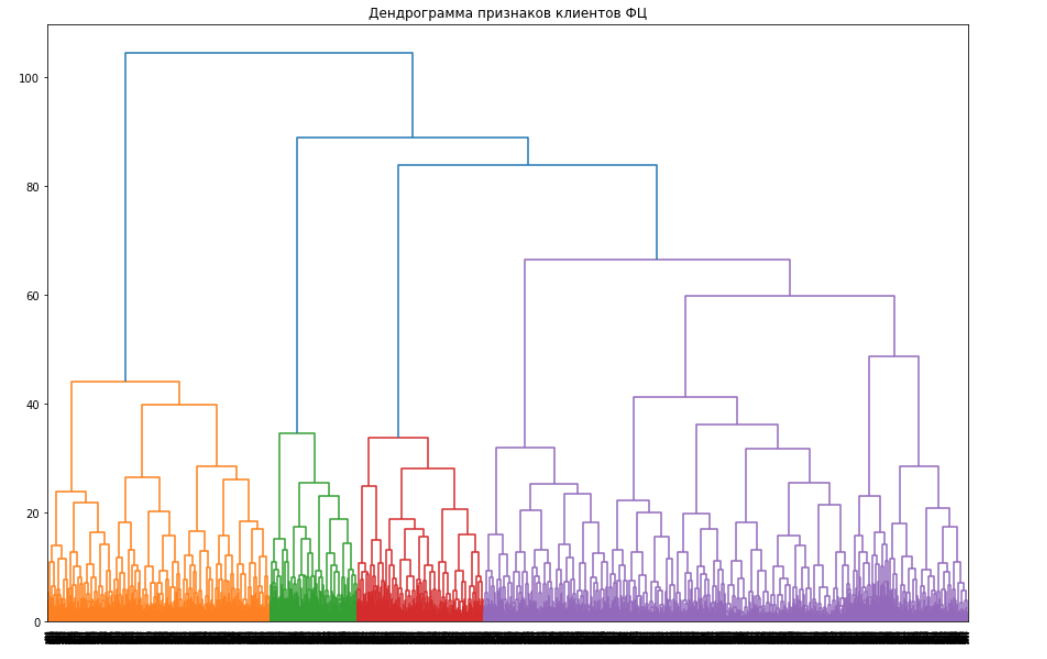

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике. В данном проекте чило кластеров будет принято за 5.

In [37]:
# задаём модель k_means с числом кластеров 5 (по заданию) и фиксируем значение random_state
km =  KMeans(n_clusters=5, random_state=0)

In [38]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

In [39]:
df['cluster_km'] = labels

In [40]:
# выводим статистику по средним значениям признаков по кластеру
clusters = df.groupby('cluster_km').mean()
clusters

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


На основании средних значений признаков в полученных кластерах, попробуем дать краткую характеристику каждому кластеру клиентов по бросающимся в глаза признакам.

**Нулевой кластер клиентов:** Живут рядом с ФЦ, в основном, сотрудники компании-партнера ФЦ. Приобретают годовые абонементы. Возраст около 30 лет. У них высокие траты на доп. услуги ФЦ.  Средний период взаимодействия с ФЦ - около 5 мес. Занимаются около 2 раз в неделю. В этой группе самый высокий показатель посещения групповых занятий. И, как следствие, в этой группе самый низкий показатель оттока (3%) - это "надежные" клиенты.

**Первый кластер клиентов:**  Не указывают контактных номеров телефона. Возраст - около 29. Берут абонементы в среднем на 5 мес. Тратят на доп. услуги умеренно (не свмай высокий, и не самый низкий показатель). Средний период взаимодействия с ФЦ - около 4 мес.  Занимаются чуть менее 2 раз в неделю. Показатель оттока - 27%. Вывод: склонны к оттоку.

**Второй кластер клиентов:** По признаку близости расположения к ФЦ: живут далеко. В этом кластере самое низкое число клиентов, использовавших промо друга. Возраст - около 28 лет. Длительность абонементов невысокая (в среднем, 2,3 мес.) Тратят на доп. услуги меньше первых двух кластеров.  Средний период взаимодействия с ФЦ - около 3 мес. Ходят на занятия, в среднем, 1,5 раза в неделю, причем в месяц, предшествующий оттоку, занимаются еще реже. Редко посещают групповые занятия.  Показатель оттока - 44%. Сильно подвержены оттоку.

**Третий кластер клиентов:** Живут рядом с ФЦ.  Возраст - около 28 лет.  Длительность абонементов самая низкая - в среднем, менее 2 мес. Тратят на доп. услуги меньше всех кластеров.  Средний период взаимодействия с ФЦ так же самый низкий - около 2,5 мес. Ходят на занятия, в среднем, менее 1,25 раза в неделю, причем в месяц, предшествующий оттоку, занимаются еще реже. Редко посещают групповые занятия.  Показатель оттока - 51%. Сильно подвержены оттоку.

**Четвертый кластер клиентов:** Живут рядом с ФЦ. Возраст - 30 лет.  Самые высокие траты на доп. услуги ФЦ. Средний период взаимодействия с ФЦ - около 5 мес. В данной группе клиентов самая высокая частота посещения занятий - около 3 раз в неделю. Показатель оттока низкий - около 7%. Вывод: "надежные" клиенты.

In [41]:
# доля оттока по кластерам в процентах
df.groupby('cluster_km')['Churn'].mean() * 100

cluster_km
0     2.772277
1    26.753247
2    44.356436
3    51.426307
4     6.801909
Name: Churn, dtype: float64

Глядя на признак оттока еще раз убедимся, что в 0-вом и 4-ом кластерах самые "надежные" клиенты, доля оттока в них крайне низкая (3% и 7%, соответственно). Кластер 1 склонен к оттоку, показатель - 27%. А вот 3-ий и 2-ой кластеры, сильнее всех подвержены оттоку. Доли ушедших клиентов составляют  51% и 44% соответственно.

Посмотрим на распределение признаков по отдельности, чтобы утвердиться в полученных выводах:

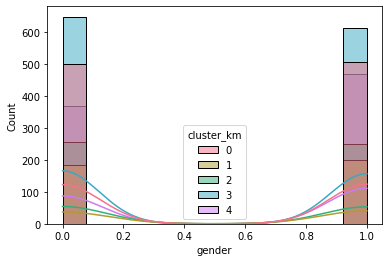

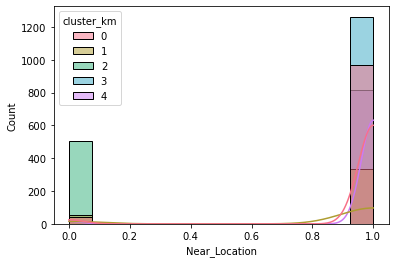

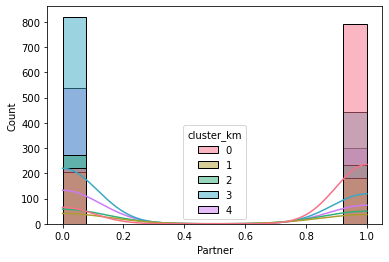

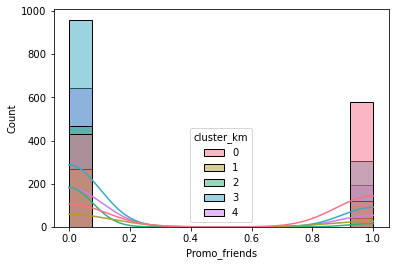

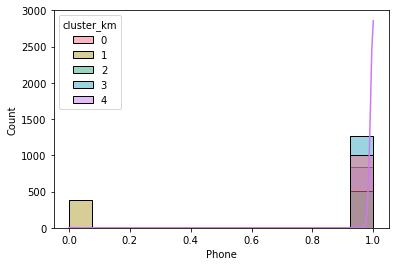

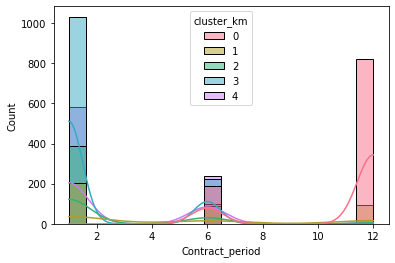

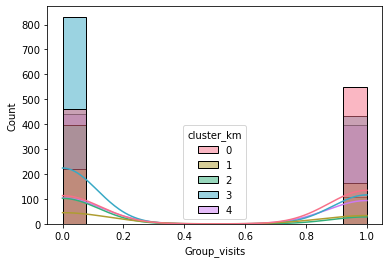

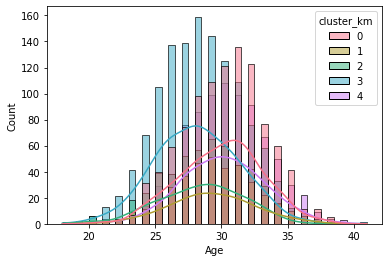

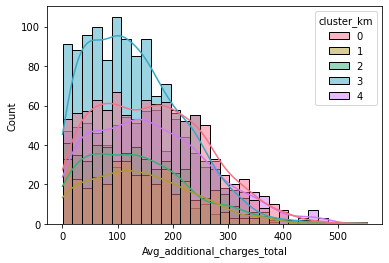

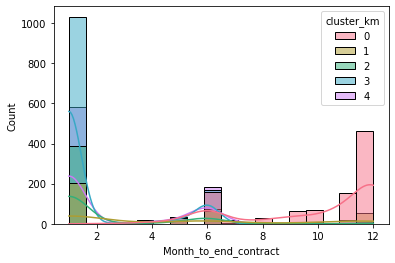

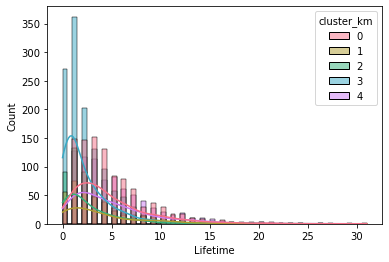

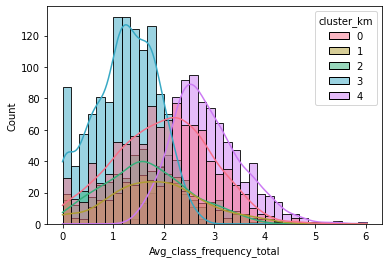

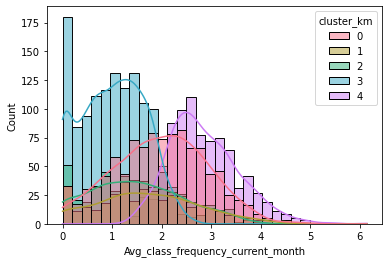

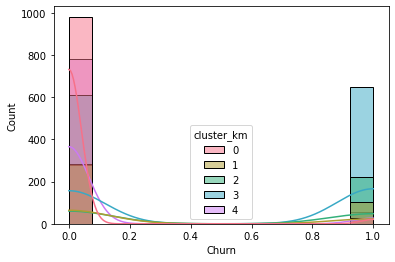

In [42]:
for col in df.drop('cluster_km', axis = 1).columns:
    sns.histplot(x=df[col], hue=df['cluster_km'],palette=sns.color_palette(palette='husl', n_colors=5),  kde=True)
    plt.show()

Глядя на графики еще раз убедимся, что сильнее всего отличия между кластерами заметны на графиках наиболее весомых признаков: средняя частота посещений ФЦ в предшствующий оттоку месяц, средняя частота посещений ФЦ в целом за все время, срок взаимодействия с ФЦ в качестве клиента. На отдельных графиках видны лидирующие позиции некоторых групп, например: есть небольшие различия по возрасту клиентов (0 и 4 кластер немного старше). Также видно, что 0, 3 и 4 кластеры живут близко к ФЦ. В нулевом кластере больше всего клиентов-партнеров ФЦ и т.д. То есть, графически подтверждаются выводы, которые мы сформировали на основе средних значений признаков в кластерах.

## Выводы по разделу:

- данные были стандартизированы;
- построена матрицу расстояний функцией linkage() на стандартизованной матрице признаков и визуализирована дендрограмма. Количество кластеров на основании дендрограммы - 4.
- обучена модель кластеризации на основании алгоритма K-Means (число кластеров n=5) 
- на основании полученных кластеров описаны основные характеристики групп и склонность к оттоку: в 0-вом и 4-ом кластерах самые "надежные" клиенты, доля оттока в них крайне низкая (3% и 7%, соответственно). Кластер 1 склонен к оттоку, показатель - 27%. А вот 3-ий и 2-ой кластеры, сильнее всех подвержены оттоку. Доли ушедших клиентов составляют  51% и 44% соответственно.

## Выводы и базовые рекомендации по работе с клиентами
<a id="conclusion_part"></a> 

Был проведено исследование клиентов фитнес-центра с целью прогнозирования возможного оттока и определения стратегии удержания клиентов. В качестве исходных данных были представлены признаки/характеристики клиента и факт оттока на следующий после взятия данных месяц.

На этапе иисследовательского анализ данных было выявлено:
- пропущенных значений не обнаружено;
- дубликатов не обнаружено;
- выбросов, способных повлиять на качество будущей модели, не обнаружено;
- исследование отдельных признаков в разрезе факта оттока показало, что некоторые из них могут оказывать влияние на целевую переменную (факт оттока) с большей вероятностью, некоторые с меньшей, что будет выявлено в дальнейшем на этапе построения модели;
- матрица корреляций позволила выявить эффект мультиколлинеарности признаков: длительность абонемента и срок до его окончания, средняя частота посещений в неделю и средняя частота посещений за предыдущий месяц сильно коррелируют между собой. С целевой переменной на данном этапе больше всего коррелируют следующие признаки: лайфтайм клиента, частота посещений за предыдущий месяц, возраст, длительность абонемента и срок до его окончания;
- качество исходных данных принято соответствующим для перехода к этапу моделирования.

На этапе обучения моделей и оценке метрик было выявлено:
- были обучены 2 модели по алгоритмам логистической регресии и случайного леса;
- обе модели показали высокие результаты по выбранным метрикам:  accuracy, precision и recall;
- на основании метрик precision и recall лучше себя показала модель логистической регрессии;
- среди наиболее влиятельных факторов были выделены: средняя частота посещений в неделю за предыдущий месяц, время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за все время с начала действия абонемента.

На этапе кластеризации клиентов было выявлено:
- обучена модель кластеризации на основании алгоритма K-Means (число кластеров n=5) 
- на основании полученных кластеров описаны основные характеристики групп и склонность к оттоку: в 0-вом и 4-ом кластерах самые "надежные" клиенты, доля оттока в них крайне низкая (3% и 7%, соответственно). Кластер 1 склонен к оттоку, показатель - 27%. А вот 3-ий и 2-ой кластеры, сильнее всех подвержены оттоку. Доли ушедших клиентов составляют  51% и 44% соответственно.

**Основные выводы:** 
Наиболее сильно подвержены оттоку клиенты:
- которые только недавно обратились за услугами в ФЦ, так называемые "новые" клиенты;
- которые приобретают краткосрочные абонементы (на 1 мес),
- которые посещают занятия, в среднем, менее 2 раз в неделю, и частота этих занятий снижается с течением времени;
- возраст которых менее 29 лет.

**Рекомендации по работе с клиентами:**
- усилить работу с "новыми" клиентами: ввести промоакции на приобретение именно долгосрочных (6 и 12 мес.) абонементов;
- поддерживать темп занятий "новых" и/или "молодых" клиентов (от недели к неделе): ввести дополнительные бонусы за посещение занятий на основании заранее определенного клиентом графика (например, скидки на доп. продукцию ФЦ, если клиент выполняет недельный график посещений или же растущий от занятия к занятию кэшбэк: если клиент не приходит, кэшбэк обнуляется);
- удерживать текущих клиентов с долгосрочными абонементами:  ввести дополнительные бонусы за суммарное количество посещенных за месяц занятий в виде повышенного кэшбэка или скидок на следующий абонемент.